# Speech Recognition with Neural Networks


## Introduction  

In this notebook, you will build a deep neural network that functions as part of an end-to-end automatic speech recognition (ASR) pipeline!  Your completed pipeline will accept raw audio as input and return a predicted transcription of the spoken language.  The full pipeline is summarized in the figure below.

<img src="images/pipeline.png">

- **STEP 1** is a pre-processing step that converts raw audio to one of two feature representations that are commonly used for ASR. 
- **STEP 2** is an acoustic model which accepts audio features as input and returns a probability distribution over all potential transcriptions. After learning about the basic types of neural networks that are often used for acoustic modeling, you will engage in your own investigations, to design your own acoustic model!
- **STEP 3** in the pipeline takes the output from the acoustic model and returns a predicted transcription.  

Feel free to use the links below to navigate the notebook:
- [The Data](#thedata)
- [**STEP 1**](#step1): Acoustic Features for Speech Recognition
- [**STEP 2**](#step2): Deep Neural Networks for Acoustic Modeling
    - [Model 0](#model0): RNN
    - [Model 1](#model1): RNN + TimeDistributed Dense
    - [Model 2](#model2): CNN + RNN + TimeDistributed Dense
    - [Model 3](#model3): Deeper RNN + TimeDistributed Dense
    - [Model 4](#model4): Bidirectional RNN + TimeDistributed Dense
    - [Models 5+](#model5)
    - [Compare the Models](#compare)
    - [Final Model](#final)
- [**STEP 3**](#step3): Obtain Predictions

<a id='thedata'></a>
## The Data

We begin by investigating the dataset that will be used to train and evaluate your pipeline.  [LibriSpeech](http://www.danielpovey.com/files/2015_icassp_librispeech.pdf) is a large corpus of English-read speech, designed for training and evaluating models for ASR.  The dataset contains 1000 hours of speech derived from audiobooks.  We will work with a small subset in this project, since larger-scale data would take a long while to train.  However, after completing this project, if you are interested in exploring further, you are encouraged to work with more of the data that is provided [online](http://www.openslr.org/12/).

In the code cells below, you will use the `vis_train_features` module to visualize a training example.  The supplied argument `index=0` tells the module to extract the first example in the training set.  (You are welcome to change `index=0` to point to a different training example, if you like, but please **DO NOT** amend any other code in the cell.)  The returned variables are:
- `vis_text` - transcribed text (label) for the training example.
- `vis_raw_audio` - raw audio waveform for the training example.
- `vis_mfcc_feature` - mel-frequency cepstral coefficients (MFCCs) for the training example.
- `vis_spectrogram_feature` - spectrogram for the training example. 
- `vis_audio_path` - the file path to the training example.

In [6]:
"""
Defines a class that is used to featurize audio clips, and provide
them to the network for training or testing.
"""

import json
import numpy as np
import random
from python_speech_features import mfcc
import librosa
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable



RNG_SEED = 123

class AudioGenerator():
    def __init__(self, step=10, window=20, max_freq=8000, mfcc_dim=13,
        minibatch_size=20, desc_file=None, spectrogram=True, max_duration=10.0, 
        sort_by_duration=False):
        """
        Params:
            step (int): Step size in milliseconds between windows (for spectrogram ONLY)
            window (int): FFT window size in milliseconds (for spectrogram ONLY)
            max_freq (int): Only FFT bins corresponding to frequencies between
                [0, max_freq] are returned (for spectrogram ONLY)
            desc_file (str, optional): Path to a JSON-line file that contains
                labels and paths to the audio files. If this is None, then
                load metadata right away
        """

        self.feat_dim = calc_feat_dim(window, max_freq)
        self.mfcc_dim = mfcc_dim
        self.feats_mean = np.zeros((self.feat_dim,))
        self.feats_std = np.ones((self.feat_dim,))
        self.rng = random.Random(RNG_SEED)
        if desc_file is not None:
            self.load_metadata_from_desc_file(desc_file)
        self.step = step
        self.window = window
        self.max_freq = max_freq
        self.cur_train_index = 0
        self.cur_valid_index = 0
        self.cur_test_index = 0
        self.max_duration=max_duration
        self.minibatch_size = minibatch_size
        self.spectrogram = spectrogram
        self.sort_by_duration = sort_by_duration

    def get_batch(self, partition):
        """ Obtain a batch of train, validation, or test data
        """
        if partition == 'train':
            audio_paths = self.train_audio_paths
            cur_index = self.cur_train_index
            texts = self.train_texts
        elif partition == 'valid':
            audio_paths = self.valid_audio_paths
            cur_index = self.cur_valid_index
            texts = self.valid_texts
        elif partition == 'test':
            audio_paths = self.test_audio_paths
            cur_index = self.test_valid_index
            texts = self.test_texts
        else:
            raise Exception("Invalid partition. "
                "Must be train/validation")

        features = [self.normalize(self.featurize(a)) for a in 
            audio_paths[cur_index:cur_index+self.minibatch_size]]

        # calculate necessary sizes
        max_length = max([features[i].shape[0] 
            for i in range(0, self.minibatch_size)])
        max_string_length = max([len(texts[cur_index+i]) 
            for i in range(0, self.minibatch_size)])
        
        # initialize the arrays
        X_data = np.zeros([self.minibatch_size, max_length, 
            self.feat_dim*self.spectrogram + self.mfcc_dim*(not self.spectrogram)])
        labels = np.ones([self.minibatch_size, max_string_length]) * 28
        input_length = np.zeros([self.minibatch_size, 1])
        label_length = np.zeros([self.minibatch_size, 1])
        
        for i in range(0, self.minibatch_size):
            # calculate X_data & input_length
            feat = features[i]
            input_length[i] = feat.shape[0]
            X_data[i, :feat.shape[0], :] = feat

            # calculate labels & label_length
            label = np.array(text_to_int_sequence(texts[cur_index+i])) 
            labels[i, :len(label)] = label
            label_length[i] = len(label)
 
        # return the arrays
        outputs = {'ctc': np.zeros([self.minibatch_size])}
        inputs = {'the_input': X_data, 
                  'the_labels': labels, 
                  'input_length': input_length, 
                  'label_length': label_length 
                 }
        return (inputs, outputs)

    def shuffle_data_by_partition(self, partition):
        """ Shuffle the training or validation data
        """
        if partition == 'train':
            self.train_audio_paths, self.train_durations, self.train_texts = shuffle_data(
                self.train_audio_paths, self.train_durations, self.train_texts)
        elif partition == 'valid':
            self.valid_audio_paths, self.valid_durations, self.valid_texts = shuffle_data(
                self.valid_audio_paths, self.valid_durations, self.valid_texts)
        else:
            raise Exception("Invalid partition. "
                "Must be train/validation")

    def sort_data_by_duration(self, partition):
        """ Sort the training or validation sets by (increasing) duration
        """
        if partition == 'train':
            self.train_audio_paths, self.train_durations, self.train_texts = sort_data(
                self.train_audio_paths, self.train_durations, self.train_texts)
        elif partition == 'valid':
            self.valid_audio_paths, self.valid_durations, self.valid_texts = sort_data(
                self.valid_audio_paths, self.valid_durations, self.valid_texts)
        else:
            raise Exception("Invalid partition. "
                "Must be train/validation")

    def next_train(self):
        """ Obtain a batch of training data
        """
        while True:
            ret = self.get_batch('train')
            self.cur_train_index += self.minibatch_size
            if self.cur_train_index >= len(self.train_texts) - self.minibatch_size:
                self.cur_train_index = 0
                self.shuffle_data_by_partition('train')
            yield ret    

    def next_valid(self):
        """ Obtain a batch of validation data
        """
        while True:
            ret = self.get_batch('valid')
            self.cur_valid_index += self.minibatch_size
            if self.cur_valid_index >= len(self.valid_texts) - self.minibatch_size:
                self.cur_valid_index = 0
                self.shuffle_data_by_partition('valid')
            yield ret

    def next_test(self):
        """ Obtain a batch of test data
        """
        while True:
            ret = self.get_batch('test')
            self.cur_test_index += self.minibatch_size
            if self.cur_test_index >= len(self.test_texts) - self.minibatch_size:
                self.cur_test_index = 0
            yield ret

    def load_train_data(self, desc_file='/content/drive/Indian-Accent-Speech-Recognition-master/train_corpus.json'):
        self.load_metadata_from_desc_file(desc_file, 'train')
        self.fit_train()
        if self.sort_by_duration:
            self.sort_data_by_duration('train')

    def load_validation_data(self, desc_file='/content/drive/Indian-Accent-Speech-Recognition-master/valid_corpus.json'):
        self.load_metadata_from_desc_file(desc_file, 'validation')
        if self.sort_by_duration:
            self.sort_data_by_duration('valid')

    def load_test_data(self, desc_file='/content/test_corpus.json'):
        self.load_metadata_from_desc_file(desc_file, 'test')
    
    def load_metadata_from_desc_file(self, desc_file, partition):
        """ Read metadata from a JSON-line file
            (possibly takes long, depending on the filesize)
        Params:
            desc_file (str):  Path to a JSON-line file that contains labels and
                paths to the audio files
            partition (str): One of 'train', 'validation' or 'test'
        """
        audio_paths, durations, texts = [], [], []
        with open(desc_file) as json_line_file:
            for line_num, json_line in enumerate(json_line_file):
                try:
                    spec = json.loads(json_line)
                    if float(spec['duration']) > self.max_duration:
                        continue
                    audio_paths.append(spec['key'])
                    durations.append(float(spec['duration']))
                    texts.append(spec['text'])
                except Exception as e:
                    # Change to (KeyError, ValueError) or
                    # (KeyError,json.decoder.JSONDecodeError), depending on
                    # json module version
                    print('Error reading line #{}: {}'
                                .format(line_num, json_line))
        if partition == 'train':
            self.train_audio_paths = audio_paths
            self.train_durations = durations
            self.train_texts = texts
        elif partition == 'validation':
            self.valid_audio_paths = audio_paths
            self.valid_durations = durations
            self.valid_texts = texts
        elif partition == 'test':
            self.test_audio_paths = audio_paths
            self.test_durations = durations
            self.test_texts = texts
        else:
            raise Exception("Invalid partition to load metadata. "
             "Must be train/validation/test")
            
    def fit_train(self, k_samples=100):
        """ Estimate the mean and std of the features from the training set
        Params:
            k_samples (int): Use this number of samples for estimation
        """
        k_samples = min(k_samples, len(self.train_audio_paths))
        samples = self.rng.sample(self.train_audio_paths, k_samples)
        feats = [self.featurize(s) for s in samples]
        feats = np.vstack(feats)
        self.feats_mean = np.mean(feats, axis=0)
        self.feats_std = np.std(feats, axis=0)
        
    def featurize(self, audio_clip):
        """ For a given audio clip, calculate the corresponding feature
        Params:
            audio_clip (str): Path to the audio clip
        """
        if self.spectrogram:
            return spectrogram_from_file(
                audio_clip, step=self.step, window=self.window,
                max_freq=self.max_freq)
        else:
            (rate, sig) = wav.read(audio_clip)
            return mfcc(sig, rate, numcep=self.mfcc_dim)

    def normalize(self, feature, eps=1e-14):
        """ Center a feature using the mean and std
        Params:
            feature (numpy.ndarray): Feature to normalize
        """
        return (feature - self.feats_mean) / (self.feats_std + eps)

def shuffle_data(audio_paths, durations, texts):
    """ Shuffle the data (called after making a complete pass through 
        training or validation data during the training process)
    Params:
        audio_paths (list): Paths to audio clips
        durations (list): Durations of utterances for each audio clip
        texts (list): Sentences uttered in each audio clip
    """
    p = np.random.permutation(len(audio_paths))
    audio_paths = [audio_paths[i] for i in p] 
    durations = [durations[i] for i in p] 
    texts = [texts[i] for i in p]
    return audio_paths, durations, texts

def sort_data(audio_paths, durations, texts):
    """ Sort the data by duration 
    Params:
        audio_paths (list): Paths to audio clips
        durations (list): Durations of utterances for each audio clip
        texts (list): Sentences uttered in each audio clip
    """
    p = np.argsort(durations).tolist()
    audio_paths = [audio_paths[i] for i in p]
    durations = [durations[i] for i in p] 
    texts = [texts[i] for i in p]
    return audio_paths, durations, texts

def vis_train_features(index=0):
    """ Visualizing the data point in the training set at the supplied index
    """
    # obtain spectrogram
    audio_gen = AudioGenerator(spectrogram=True)
    audio_gen.load_train_data()
    vis_audio_path = audio_gen.train_audio_paths[index]
    vis_spectrogram_feature = audio_gen.normalize(audio_gen.featurize(vis_audio_path))
    # obtain mfcc
    audio_gen = AudioGenerator(spectrogram=False)
    audio_gen.load_train_data()
    vis_mfcc_feature = audio_gen.normalize(audio_gen.featurize(vis_audio_path))
    # obtain text label
    vis_text = audio_gen.train_texts[index]
    # obtain raw audio
    vis_raw_audio, _ = librosa.load(vis_audio_path)
    # print total number of training examples
    print('There are %d total training examples.' % len(audio_gen.train_audio_paths))
    # return labels for plotting
    return vis_text, vis_raw_audio, vis_mfcc_feature, vis_spectrogram_feature, vis_audio_path


def plot_raw_audio(vis_raw_audio):
    # plot the raw audio signal
    fig = plt.figure(figsize=(12,3))
    ax = fig.add_subplot(111)
    steps = len(vis_raw_audio)
    ax.plot(np.linspace(1, steps, steps), vis_raw_audio)
    plt.title('Audio Signal')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.show()

def plot_mfcc_feature(vis_mfcc_feature):
    # plot the MFCC feature
    fig = plt.figure(figsize=(12,5))
    ax = fig.add_subplot(111)
    im = ax.imshow(vis_mfcc_feature, cmap=plt.cm.jet, aspect='auto')
    plt.title('Normalized MFCC')
    plt.ylabel('Time')
    plt.xlabel('MFCC Coefficient')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    ax.set_xticks(np.arange(0, 13, 2), minor=False);
    plt.show()

def plot_spectrogram_feature(vis_spectrogram_feature):
    # plot the normalized spectrogram
    fig = plt.figure(figsize=(12,5))
    ax = fig.add_subplot(111)
    im = ax.imshow(vis_spectrogram_feature, cmap=plt.cm.jet, aspect='auto')
    plt.title('Normalized Spectrogram')
    plt.ylabel('Time')
    plt.xlabel('Frequency')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    plt.show()


In [5]:
!pip install 'python_speech_features'

  Created wheel for python-speech-features: filename=python_speech_features-0.6-py3-none-any.whl size=5888 sha256=c7e43ad2a3252058b763201f6234692b2aeaa9dc33645a2c0f39606cd9b8ec2e
  Stored in directory: /root/.cache/pip/wheels/b0/0e/94/28cd6afa3cd5998a63eef99fe31777acd7d758f59cf24839eb
Successfully built python-speech-features


In [7]:
from keras import backend as K
from keras.models import Model
from keras.layers import (BatchNormalization, Conv1D, Dense, Input, 
    TimeDistributed, Activation, Bidirectional, SimpleRNN, GRU, LSTM, MaxPooling1D)

def simple_rnn_model(input_dim, output_dim=29):
    """ Build a recurrent network for speech 
    """
    # Main acoustic input
    input_data = Input(name='the_input', shape=(None, input_dim))
    # Add recurrent layer
    simp_rnn = GRU(output_dim, return_sequences=True, 
                 implementation=2, name='rnn')(input_data)
    # Add softmax activation layer
    y_pred = Activation('softmax', name='softmax')(simp_rnn)
    # Specify the model
    model = Model(inputs=input_data, outputs=y_pred)
    model.output_length = lambda x: x
    print(model.summary())
    return model

def rnn_model(input_dim, units, activation, output_dim=29):
    """ Build a recurrent network for speech 
    """
    # Main acoustic input
    input_data = Input(name='the_input', shape=(None, input_dim))
    # Add recurrent layer
    simp_rnn = GRU(units, activation=activation,
        return_sequences=True, implementation=2, name='rnn')(input_data)
    # TODO: Add batch normalization 
    bn_rnn = BatchNormalization(name='simp_rnn')(simp_rnn)
    # TODO: Add a TimeDistributed(Dense(output_dim)) layer
    time_dense = TimeDistributed(Dense(output_dim))(bn_rnn)
    # Add softmax activation layer
    y_pred = Activation('softmax', name='softmax')(time_dense)
    # Specify the model
    model = Model(inputs=input_data, outputs=y_pred)
    model.output_length = lambda x: x
    print(model.summary())
    return model


def cnn_rnn_model(input_dim, filters, kernel_size, conv_stride,
    conv_border_mode, units, output_dim=29):
    """ Build a recurrent + convolutional network for speech 
    """
    # Main acoustic input
    input_data = Input(name='the_input', shape=(None, input_dim))
    # Add convolutional layer
    conv_1d = Conv1D(filters, kernel_size, 
                     strides=conv_stride, 
                     padding=conv_border_mode,
                     activation='relu',
                     name='conv1d')(input_data)
    # Add batch normalization
    bn_cnn = BatchNormalization(name='bn_conv_1d')(conv_1d)
    # Add a recurrent layer
    simp_rnn = SimpleRNN(units, activation='relu',
        return_sequences=True, implementation=2, name='rnn')(bn_cnn)
    # TODO: Add batch normalization
    bn_rnn = BatchNormalization(name='simp_rnn')(simp_rnn)
    # TODO: Add a TimeDistributed(Dense(output_dim)) layer
    time_dense = TimeDistributed(Dense(output_dim))(bn_rnn)
    # Add softmax activation layer
    y_pred = Activation('softmax', name='softmax')(time_dense)
    # Specify the model
    model = Model(inputs=input_data, outputs=y_pred)
    model.output_length = lambda x: cnn_output_length(
        x, kernel_size, conv_border_mode, conv_stride)
    print(model.summary())
    return model

def cnn_output_length(input_length, filter_size, border_mode, stride,
                       dilation=1):
    """ Compute the length of the output sequence after 1D convolution along
        time. Note that this function is in line with the function used in
        Convolution1D class from Keras.
    Params:
        input_length (int): Length of the input sequence.
        filter_size (int): Width of the convolution kernel.
        border_mode (str): Only support `same` or `valid`.
        stride (int): Stride size used in 1D convolution.
        dilation (int)
    """
    if input_length is None:
        return None
    assert border_mode in {'same', 'valid'}
    dilated_filter_size = filter_size + (filter_size - 1) * (dilation - 1)
    if border_mode == 'same':
        output_length = input_length
    elif border_mode == 'valid':
        output_length = input_length - dilated_filter_size + 1
    return (output_length + stride - 1) // stride

def deep_rnn_model(input_dim, units, recur_layers, output_dim=29):
    """ Build a deep recurrent network for speech 
    """
    # Main acoustic input
    input_data = Input(name='the_input', shape=(None, input_dim))
    # TODO: Add recurrent layers, each with batch normalization
    prev_layer = input_data
    for layer in range(recur_layers):
        prev_layer = GRU(units, activation='relu',
            return_sequences=True, implementation=2, name=f'rnn_{layer+1}')(prev_layer)
        # TODO: Add batch normalization
        prev_layer = BatchNormalization()(prev_layer)
    
    # TODO: Add a TimeDistributed(Dense(output_dim)) layer
    time_dense = TimeDistributed(Dense(output_dim))(prev_layer)
    # Add softmax activation layer
    y_pred = Activation('softmax', name='softmax')(time_dense)
    # Specify the model
    model = Model(inputs=input_data, outputs=y_pred)
    model.output_length = lambda x: x
    print(model.summary())
    return model

def bidirectional_rnn_model(input_dim, units, output_dim=29):
    """ Build a bidirectional recurrent network for speech
    """
    # Main acoustic input
    input_data = Input(name='the_input', shape=(None, input_dim))
    # TODO: Add bidirectional recurrent layer
    bidir_rnn = Bidirectional(GRU(units, activation='relu',
            return_sequences=True, implementation=2, name='bi-rnn'))(input_data)
    # TODO: Add a TimeDistributed(Dense(output_dim)) layer
    time_dense = TimeDistributed(Dense(output_dim))(bidir_rnn)
    # Add softmax activation layer
    y_pred = Activation('softmax', name='softmax')(time_dense)
    # Specify the model
    model = Model(inputs=input_data, outputs=y_pred)
    model.output_length = lambda x: x
    print(model.summary())
    return model

def final_model(input_dim, filters, kernel_size, conv_stride, 
                conv_border_mode, units, recur_layers, output_dim=29):
    """ Build a deep network for speech 
    """
    # Main acoustic input
    input_data = Input(name='the_input', shape=(None, input_dim))
    # TODO: Specify the layers in your network
    # Add convolutional layer
    conv_1d = Conv1D(filters, kernel_size, 
                     strides=conv_stride, 
                     padding=conv_border_mode,
                     activation='relu',
                     name='conv1d')(input_data)
    pooled_1d = MaxPooling1D(pool_size=2, strides=1)(conv_1d)
    # Add batch normalization
    bn_cnn = BatchNormalization(name='bn_conv_1d')(pooled_1d)
    
    prev_layer = bn_cnn
    for layer in range(recur_layers):
        prev_layer = Bidirectional(GRU(units, activation='relu',
            return_sequences=True, implementation=2, name=f'gru_{layer+1}'))(prev_layer)
        # TODO: Add batch normalization
        prev_layer = BatchNormalization()(prev_layer)
    
    # TODO: Add a TimeDistributed(Dense(output_dim)) layer
    time_dense = TimeDistributed(Dense(output_dim))(prev_layer)
    
    # TODO: Add softmax activation layer
    y_pred = Activation('softmax', name='softmax')(time_dense)
    # Specify the model
    model = Model(inputs=input_data, outputs=y_pred)
    # TODO: Specify model.output_length
    model.output_length = lambda x: cnn_output_length(
        x, kernel_size, conv_border_mode, conv_stride)/2
    print(model.summary())
    return model


In [20]:
pip install soundfile

In [8]:
"""
Defines various functions for processing the data.
"""
import numpy as np
import soundfile
from numpy.lib.stride_tricks import as_strided


def calc_feat_dim(window, max_freq):
    return int(0.001 * window * max_freq) + 1

def conv_output_length(input_length, filter_size, border_mode, stride,
                       dilation=1):
    """ Compute the length of the output sequence after 1D convolution along
        time. Note that this function is in line with the function used in
        Convolution1D class from Keras.
    Params:
        input_length (int): Length of the input sequence.
        filter_size (int): Width of the convolution kernel.
        border_mode (str): Only support `same` or `valid`.
        stride (int): Stride size used in 1D convolution.
        dilation (int)
    """
    if input_length is None:
        return None
    assert border_mode in {'same', 'valid'}
    dilated_filter_size = filter_size + (filter_size - 1) * (dilation - 1)
    if border_mode == 'same':
        output_length = input_length
    elif border_mode == 'valid':
        output_length = input_length - dilated_filter_size + 1
    return (output_length + stride - 1) // stride


def spectrogram(samples, fft_length=256, sample_rate=2, hop_length=128):
    """
    Compute the spectrogram for a real signal.
    The parameters follow the naming convention of
    matplotlib.mlab.specgram

    Args:
        samples (1D array): input audio signal
        fft_length (int): number of elements in fft window
        sample_rate (scalar): sample rate
        hop_length (int): hop length (relative offset between neighboring
            fft windows).

    Returns:
        x (2D array): spectrogram [frequency x time]
        freq (1D array): frequency of each row in x

    Note:
        This is a truncating computation e.g. if fft_length=10,
        hop_length=5 and the signal has 23 elements, then the
        last 3 elements will be truncated.
    """
    assert not np.iscomplexobj(samples), "Must not pass in complex numbers"

    window = np.hanning(fft_length)[:, None]
    window_norm = np.sum(window**2)

    # The scaling below follows the convention of
    # matplotlib.mlab.specgram which is the same as
    # matlabs specgram.
    scale = window_norm * sample_rate

    trunc = (len(samples) - fft_length) % hop_length
    x = samples[:len(samples) - trunc]

    # "stride trick" reshape to include overlap
    nshape = (fft_length, (len(x) - fft_length) // hop_length + 1)
    nstrides = (x.strides[0], x.strides[0] * hop_length)
    x = as_strided(x, shape=nshape, strides=nstrides)

    # window stride sanity check
    assert np.all(x[:, 1] == samples[hop_length:(hop_length + fft_length)])

    # broadcast window, compute fft over columns and square mod
    x = np.fft.rfft(x * window, axis=0)
    x = np.absolute(x)**2

    # scale, 2.0 for everything except dc and fft_length/2
    x[1:-1, :] *= (2.0 / scale)
    x[(0, -1), :] /= scale

    freqs = float(sample_rate) / fft_length * np.arange(x.shape[0])

    return x, freqs


def spectrogram_from_file(filename, step=10, window=20, max_freq=None,
                          eps=1e-14):
    """ Calculate the log of linear spectrogram from FFT energy
    Params:
        filename (str): Path to the audio file
        step (int): Step size in milliseconds between windows
        window (int): FFT window size in milliseconds
        max_freq (int): Only FFT bins corresponding to frequencies between
            [0, max_freq] are returned
        eps (float): Small value to ensure numerical stability (for ln(x))
    """
    with soundfile.SoundFile(filename) as sound_file:
        audio = sound_file.read(dtype='float32')
        sample_rate = sound_file.samplerate
        if audio.ndim >= 2:
            audio = np.mean(audio, 1)
        if max_freq is None:
            max_freq = sample_rate / 2
        if max_freq > sample_rate / 2:
            raise ValueError("max_freq must not be greater than half of "
                             " sample rate")
        if step > window:
            raise ValueError("step size must not be greater than window size")
        hop_length = int(0.001 * step * sample_rate)
        fft_length = int(0.001 * window * sample_rate)
        pxx, freqs = spectrogram(
            audio, fft_length=fft_length, sample_rate=sample_rate,
            hop_length=hop_length)
        ind = np.where(freqs <= max_freq)[0][-1] + 1
    return np.transpose(np.log(pxx[:ind, :] + eps))

def text_to_int_sequence(text):
    """ Convert text to an integer sequence """
    int_sequence = []
    for c in text:
        if c == ' ':
            ch = char_map['<SPACE>']
        else:
            ch = char_map[c]
        int_sequence.append(ch)
    return int_sequence

def int_sequence_to_text(int_sequence):
    """ Convert an integer sequence to text """
    text = []
    for c in int_sequence:
        ch = index_map[c]
        text.append(ch)
    return text


In [9]:
"""
Defines a class that is used to featurize audio clips, and provide
them to the network for training or testing.
"""

import json
import numpy as np
import random
from python_speech_features import mfcc
import librosa
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable



RNG_SEED = 123

class AudioGenerator():
    def __init__(self, step=10, window=20, max_freq=8000, mfcc_dim=13,
        minibatch_size=20, desc_file=None, spectrogram=True, max_duration=10.0, 
        sort_by_duration=False):
        """
        Params:
            step (int): Step size in milliseconds between windows (for spectrogram ONLY)
            window (int): FFT window size in milliseconds (for spectrogram ONLY)
            max_freq (int): Only FFT bins corresponding to frequencies between
                [0, max_freq] are returned (for spectrogram ONLY)
            desc_file (str, optional): Path to a JSON-line file that contains
                labels and paths to the audio files. If this is None, then
                load metadata right away
        """

        self.feat_dim = calc_feat_dim(window, max_freq)
        self.mfcc_dim = mfcc_dim
        self.feats_mean = np.zeros((self.feat_dim,))
        self.feats_std = np.ones((self.feat_dim,))
        self.rng = random.Random(RNG_SEED)
        if desc_file is not None:
            self.load_metadata_from_desc_file(desc_file)
        self.step = step
        self.window = window
        self.max_freq = max_freq
        self.cur_train_index = 0
        self.cur_valid_index = 0
        self.cur_test_index = 0
        self.max_duration=max_duration
        self.minibatch_size = minibatch_size
        self.spectrogram = spectrogram
        self.sort_by_duration = sort_by_duration

    def get_batch(self, partition):
        """ Obtain a batch of train, validation, or test data
        """
        if partition == 'train':
            audio_paths = self.train_audio_paths
            cur_index = self.cur_train_index
            texts = self.train_texts
        elif partition == 'valid':
            audio_paths = self.valid_audio_paths
            cur_index = self.cur_valid_index
            texts = self.valid_texts
        elif partition == 'test':
            audio_paths = self.test_audio_paths
            cur_index = self.test_valid_index
            texts = self.test_texts
        else:
            raise Exception("Invalid partition. "
                "Must be train/validation")

        features = [self.normalize(self.featurize(a)) for a in 
            audio_paths[cur_index:cur_index+self.minibatch_size]]

        # calculate necessary sizes
        max_length = max([features[i].shape[0] 
            for i in range(0, self.minibatch_size)])
        max_string_length = max([len(texts[cur_index+i]) 
            for i in range(0, self.minibatch_size)])
        
        # initialize the arrays
        X_data = np.zeros([self.minibatch_size, max_length, 
            self.feat_dim*self.spectrogram + self.mfcc_dim*(not self.spectrogram)])
        labels = np.ones([self.minibatch_size, max_string_length]) * 28
        input_length = np.zeros([self.minibatch_size, 1])
        label_length = np.zeros([self.minibatch_size, 1])
        
        for i in range(0, self.minibatch_size):
            # calculate X_data & input_length
            feat = features[i]
            input_length[i] = feat.shape[0]
            X_data[i, :feat.shape[0], :] = feat

            # calculate labels & label_length
            label = np.array(text_to_int_sequence(texts[cur_index+i])) 
            labels[i, :len(label)] = label
            label_length[i] = len(label)
 
        # return the arrays
        outputs = {'ctc': np.zeros([self.minibatch_size])}
        inputs = {'the_input': X_data, 
                  'the_labels': labels, 
                  'input_length': input_length, 
                  'label_length': label_length 
                 }
        return (inputs, outputs)

    def shuffle_data_by_partition(self, partition):
        """ Shuffle the training or validation data
        """
        if partition == 'train':
            self.train_audio_paths, self.train_durations, self.train_texts = shuffle_data(
                self.train_audio_paths, self.train_durations, self.train_texts)
        elif partition == 'valid':
            self.valid_audio_paths, self.valid_durations, self.valid_texts = shuffle_data(
                self.valid_audio_paths, self.valid_durations, self.valid_texts)
        else:
            raise Exception("Invalid partition. "
                "Must be train/validation")

    def sort_data_by_duration(self, partition):
        """ Sort the training or validation sets by (increasing) duration
        """
        if partition == 'train':
            self.train_audio_paths, self.train_durations, self.train_texts = sort_data(
                self.train_audio_paths, self.train_durations, self.train_texts)
        elif partition == 'valid':
            self.valid_audio_paths, self.valid_durations, self.valid_texts = sort_data(
                self.valid_audio_paths, self.valid_durations, self.valid_texts)
        else:
            raise Exception("Invalid partition. "
                "Must be train/validation")

    def next_train(self):
        """ Obtain a batch of training data
        """
        while True:
            ret = self.get_batch('train')
            self.cur_train_index += self.minibatch_size
            if self.cur_train_index >= len(self.train_texts) - self.minibatch_size:
                self.cur_train_index = 0
                self.shuffle_data_by_partition('train')
            yield ret    

    def next_valid(self):
        """ Obtain a batch of validation data
        """
        while True:
            ret = self.get_batch('valid')
            self.cur_valid_index += self.minibatch_size
            if self.cur_valid_index >= len(self.valid_texts) - self.minibatch_size:
                self.cur_valid_index = 0
                self.shuffle_data_by_partition('valid')
            yield ret

    def next_test(self):
        """ Obtain a batch of test data
        """
        while True:
            ret = self.get_batch('test')
            self.cur_test_index += self.minibatch_size
            if self.cur_test_index >= len(self.test_texts) - self.minibatch_size:
                self.cur_test_index = 0
            yield ret

    def load_train_data(self, desc_file='/content/drive/MyDrive/asr/Indian-Accent-Speech-Recognition-master/train_corpus.json'):
        self.load_metadata_from_desc_file(desc_file, 'train')
        self.fit_train()
        if self.sort_by_duration:
            self.sort_data_by_duration('train')

    def load_validation_data(self, desc_file='/content/drive/MyDrive/asr/Indian-Accent-Speech-Recognition-master/valid_corpus.json'):
        self.load_metadata_from_desc_file(desc_file, 'validation')
        if self.sort_by_duration:
            self.sort_data_by_duration('valid')

    def load_test_data(self, desc_file='test_corpus.json'):
        self.load_metadata_from_desc_file(desc_file, 'test')
    
    def load_metadata_from_desc_file(self, desc_file, partition):
        """ Read metadata from a JSON-line file
            (possibly takes long, depending on the filesize)
        Params:
            desc_file (str):  Path to a JSON-line file that contains labels and
                paths to the audio files
            partition (str): One of 'train', 'validation' or 'test'
        """
        audio_paths, durations, texts = [], [], []
        with open(desc_file) as json_line_file:
            for line_num, json_line in enumerate(json_line_file):
                try:
                    spec = json.loads(json_line)
                    if float(spec['duration']) > self.max_duration:
                        continue
                    audio_paths.append(spec['key'])
                    durations.append(float(spec['duration']))
                    texts.append(spec['text'])
                except Exception as e:
                    # Change to (KeyError, ValueError) or
                    # (KeyError,json.decoder.JSONDecodeError), depending on
                    # json module version
                    print('Error reading line #{}: {}'
                                .format(line_num, json_line))
        if partition == 'train':
            self.train_audio_paths = audio_paths
            self.train_durations = durations
            self.train_texts = texts
        elif partition == 'validation':
            self.valid_audio_paths = audio_paths
            self.valid_durations = durations
            self.valid_texts = texts
        elif partition == 'test':
            self.test_audio_paths = audio_paths
            self.test_durations = durations
            self.test_texts = texts
        else:
            raise Exception("Invalid partition to load metadata. "
             "Must be train/validation/test")
            
    def fit_train(self, k_samples=100):
        """ Estimate the mean and std of the features from the training set
        Params:
            k_samples (int): Use this number of samples for estimation
        """
        k_samples = min(k_samples, len(self.train_audio_paths))
        samples = self.rng.sample(self.train_audio_paths, k_samples)
        feats = [self.featurize(s) for s in samples]
        feats = np.vstack(feats)
        self.feats_mean = np.mean(feats, axis=0)
        self.feats_std = np.std(feats, axis=0)
        
    def featurize(self, audio_clip):
        """ For a given audio clip, calculate the corresponding feature
        Params:
            audio_clip (str): Path to the audio clip
        """
        if self.spectrogram:
            return spectrogram_from_file(
                audio_clip, step=self.step, window=self.window,
                max_freq=self.max_freq)
        else:
            (rate, sig) = wav.read(audio_clip)
            return mfcc(sig, rate, numcep=self.mfcc_dim)

    def normalize(self, feature, eps=1e-14):
        """ Center a feature using the mean and std
        Params:
            feature (numpy.ndarray): Feature to normalize
        """
        return (feature - self.feats_mean) / (self.feats_std + eps)

def shuffle_data(audio_paths, durations, texts):
    """ Shuffle the data (called after making a complete pass through 
        training or validation data during the training process)
    Params:
        audio_paths (list): Paths to audio clips
        durations (list): Durations of utterances for each audio clip
        texts (list): Sentences uttered in each audio clip
    """
    p = np.random.permutation(len(audio_paths))
    audio_paths = [audio_paths[i] for i in p] 
    durations = [durations[i] for i in p] 
    texts = [texts[i] for i in p]
    return audio_paths, durations, texts

def sort_data(audio_paths, durations, texts):
    """ Sort the data by duration 
    Params:
        audio_paths (list): Paths to audio clips
        durations (list): Durations of utterances for each audio clip
        texts (list): Sentences uttered in each audio clip
    """
    p = np.argsort(durations).tolist()
    audio_paths = [audio_paths[i] for i in p]
    durations = [durations[i] for i in p] 
    texts = [texts[i] for i in p]
    return audio_paths, durations, texts

def vis_train_features(index=0):
    """ Visualizing the data point in the training set at the supplied index
    """
    # obtain spectrogram
    audio_gen = AudioGenerator(spectrogram=True)
    audio_gen.load_train_data()
    vis_audio_path = audio_gen.train_audio_paths[index]
    vis_spectrogram_feature = audio_gen.normalize(audio_gen.featurize(vis_audio_path))
    # obtain mfcc
    audio_gen = AudioGenerator(spectrogram=False)
    audio_gen.load_train_data()
    vis_mfcc_feature = audio_gen.normalize(audio_gen.featurize(vis_audio_path))
    # obtain text label
    vis_text = audio_gen.train_texts[index]
    # obtain raw audio
    vis_raw_audio, _ = librosa.load(vis_audio_path)
    # print total number of training examples
    print('There are %d total training examples.' % len(audio_gen.train_audio_paths))
    # return labels for plotting
    return vis_text, vis_raw_audio, vis_mfcc_feature, vis_spectrogram_feature, vis_audio_path


def plot_raw_audio(vis_raw_audio):
    # plot the raw audio signal
    fig = plt.figure(figsize=(12,3))
    ax = fig.add_subplot(111)
    steps = len(vis_raw_audio)
    ax.plot(np.linspace(1, steps, steps), vis_raw_audio)
    plt.title('Audio Signal')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.show()

def plot_mfcc_feature(vis_mfcc_feature):
    # plot the MFCC feature
    fig = plt.figure(figsize=(12,5))
    ax = fig.add_subplot(111)
    im = ax.imshow(vis_mfcc_feature, cmap=plt.cm.jet, aspect='auto')
    plt.title('Normalized MFCC')
    plt.ylabel('Time')
    plt.xlabel('MFCC Coefficient')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    ax.set_xticks(np.arange(0, 13, 2), minor=False);
    plt.show()

def plot_spectrogram_feature(vis_spectrogram_feature):
    # plot the normalized spectrogram
    fig = plt.figure(figsize=(12,5))
    ax = fig.add_subplot(111)
    im = ax.imshow(vis_spectrogram_feature, cmap=plt.cm.jet, aspect='auto')
    plt.title('Normalized Spectrogram')
    plt.ylabel('Time')
    plt.xlabel('Frequency')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    plt.show()


In [10]:
import numpy as np
import soundfile
from numpy.lib.stride_tricks import as_strided
#from char_map import char_map , index_map

def calc_feat_dim(window, max_freq):
    return int(0.001 * window * max_freq) + 1

def conv_output_length(input_length, filter_size, border_mode, stride,
                       dilation=1):
    """ Compute the length of the output sequence after 1D convolution along
        time. Note that this function is in line with the function used in
        Convolution1D class from Keras.
    Params:
        input_length (int): Length of the input sequence.
        filter_size (int): Width of the convolution kernel.
        border_mode (str): Only support `same` or `valid`.
        stride (int): Stride size used in 1D convolution.
        dilation (int)
    """
    if input_length is None:
        return None
    assert border_mode in {'same', 'valid'}
    dilated_filter_size = filter_size + (filter_size - 1) * (dilation - 1)
    if border_mode == 'same':
        output_length = input_length
    elif border_mode == 'valid':
        output_length = input_length - dilated_filter_size + 1
    return (output_length + stride - 1) // stride


def spectrogram(samples, fft_length=256, sample_rate=2, hop_length=128):
    """
    Compute the spectrogram for a real signal.
    The parameters follow the naming convention of
    matplotlib.mlab.specgram

    Args:
        samples (1D array): input audio signal
        fft_length (int): number of elements in fft window
        sample_rate (scalar): sample rate
        hop_length (int): hop length (relative offset between neighboring
            fft windows).

    Returns:
        x (2D array): spectrogram [frequency x time]
        freq (1D array): frequency of each row in x

    Note:
        This is a truncating computation e.g. if fft_length=10,
        hop_length=5 and the signal has 23 elements, then the
        last 3 elements will be truncated.
    """
    assert not np.iscomplexobj(samples), "Must not pass in complex numbers"

    window = np.hanning(fft_length)[:, None]
    window_norm = np.sum(window**2)

    # The scaling below follows the convention of
    # matplotlib.mlab.specgram which is the same as
    # matlabs specgram.
    scale = window_norm * sample_rate

    trunc = (len(samples) - fft_length) % hop_length
    x = samples[:len(samples) - trunc]

    # "stride trick" reshape to include overlap
    nshape = (fft_length, (len(x) - fft_length) // hop_length + 1)
    nstrides = (x.strides[0], x.strides[0] * hop_length)
    x = as_strided(x, shape=nshape, strides=nstrides)

    # window stride sanity check
    assert np.all(x[:, 1] == samples[hop_length:(hop_length + fft_length)])

    # broadcast window, compute fft over columns and square mod
    x = np.fft.rfft(x * window, axis=0)
    x = np.absolute(x)**2

    # scale, 2.0 for everything except dc and fft_length/2
    x[1:-1, :] *= (2.0 / scale)
    x[(0, -1), :] /= scale

    freqs = float(sample_rate) / fft_length * np.arange(x.shape[0])

    return x, freqs


def spectrogram_from_file(filename, step=10, window=20, max_freq=None,
                          eps=1e-14):
    """ Calculate the log of linear spectrogram from FFT energy
    Params:
        filename (str): Path to the audio file
        step (int): Step size in milliseconds between windows
        window (int): FFT window size in milliseconds
        max_freq (int): Only FFT bins corresponding to frequencies between
            [0, max_freq] are returned
        eps (float): Small value to ensure numerical stability (for ln(x))
    """
    with soundfile.SoundFile(filename) as sound_file:
        audio = sound_file.read(dtype='float32')
        sample_rate = sound_file.samplerate
        if audio.ndim >= 2:
            audio = np.mean(audio, 1)
        if max_freq is None:
            max_freq = sample_rate / 2
        if max_freq > sample_rate / 2:
            raise ValueError("max_freq must not be greater than half of "
                             " sample rate")
        if step > window:
            raise ValueError("step size must not be greater than window size")
        hop_length = int(0.001 * step * sample_rate)
        fft_length = int(0.001 * window * sample_rate)
        pxx, freqs = spectrogram(
            audio, fft_length=fft_length, sample_rate=sample_rate,
            hop_length=hop_length)
        ind = np.where(freqs <= max_freq)[0][-1] + 1
    return np.transpose(np.log(pxx[:ind, :] + eps))

def text_to_int_sequence(text):
    """ Convert text to an integer sequence """
    int_sequence = []
    for c in text:
        if c == ' ':
            ch = char_map['<SPACE>']
        else:
            ch = char_map[c]
        int_sequence.append(ch)
    return int_sequence

def int_sequence_to_text(int_sequence):
    """ Convert an integer sequence to text """
    text = []
    for c in int_sequence:
        ch = index_map[c]
        text.append(ch)
    return text


In [11]:
"""
Defines two dictionaries for converting 
between text and integer sequences.
"""

char_map_str = """
' 0
<SPACE> 1
a 2
b 3
c 4
d 5
e 6
f 7
g 8
h 9
i 10
j 11
k 12
l 13
m 14
n 15
o 16
p 17
q 18
r 19
s 20
t 21
u 22
v 23
w 24
x 25
y 26
z 27
"""
# the "blank" character is mapped to 28

char_map = {}
index_map = {}
for line in char_map_str.strip().split('\n'):
    ch, index = line.split()
    char_map[ch] = int(index)
    index_map[int(index)+1] = ch
index_map[2] = ' '

In [12]:
!pip install 'python-utils'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
import sys
sys.path.insert(0,"/content/drive/ColabNotebooks")

The following code cell visualizes the audio waveform for your chosen example, along with the corresponding transcript.  You also have the option to play the audio in the notebook!

In [14]:
from IPython.display import Markdown, display
from IPython.display import Audio
%matplotlib inline

# plot audio signal
plot_raw_audio(vis_raw_audio)
# print length of audio signal
display(Markdown('**Shape of Audio Signal** : ' + str(vis_raw_audio.shape)))
# print transcript corresponding to audio clip
display(Markdown('**Transcript** : ' + str(vis_text)))
# play the audio file
Audio(vis_audio_path)

NameError: ignored

<a id='step1'></a>
## STEP 1: Acoustic Features for Speech Recognition

For this project, you won't use the raw audio waveform as input to your model.  Instead, we provide code that first performs a pre-processing step to convert the raw audio to a feature representation that has historically proven successful for ASR models.  Your acoustic model will accept the feature representation as input.

In this project, you will explore two possible feature representations.  _After completing the project_, if you'd like to read more about deep learning architectures that can accept raw audio input, you are encouraged to explore this [research paper](https://pdfs.semanticscholar.org/a566/cd4a8623d661a4931814d9dffc72ecbf63c4.pdf).

### Spectrograms

The first option for an audio feature representation is the [spectrogram](https://www.youtube.com/watch?v=_FatxGN3vAM).  In order to complete this project, you will **not** need to dig deeply into the details of how a spectrogram is calculated; but, if you are curious, the code for calculating the spectrogram was borrowed from [this repository](https://github.com/baidu-research/ba-dls-deepspeech).  The implementation appears in the `utils.py` file in your repository.

The code that we give you returns the spectrogram as a 2D tensor, where the first (_vertical_) dimension indexes time, and the second (_horizontal_) dimension indexes frequency.  To speed the convergence of your algorithm, we have also normalized the spectrogram.  (You can see this quickly in the visualization below by noting that the mean value hovers around zero, and most entries in the tensor assume values close to zero.)

In [ ]:


# plot normalized spectrogram
plot_spectrogram_feature(vis_spectrogram_feature)
# print shape of spectrogram
display(Markdown('**Shape of Spectrogram** : ' + str(vis_spectrogram_feature.shape)))

NameError: ignored

### Mel-Frequency Cepstral Coefficients (MFCCs)

The second option for an audio feature representation is [MFCCs](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum).  You do **not** need to dig deeply into the details of how MFCCs are calculated, but if you would like more information, you are welcome to peruse the [documentation](https://github.com/jameslyons/python_speech_features) of the `python_speech_features` Python package.  Just as with the spectrogram features, the MFCCs are normalized in the supplied code.

The main idea behind MFCC features is the same as spectrogram features: at each time window, the MFCC feature yields a feature vector that characterizes the sound within the window.  **Note that the MFCC feature is much lower-dimensional than the spectrogram feature, which could help an acoustic model to avoid overfitting to the training dataset.**

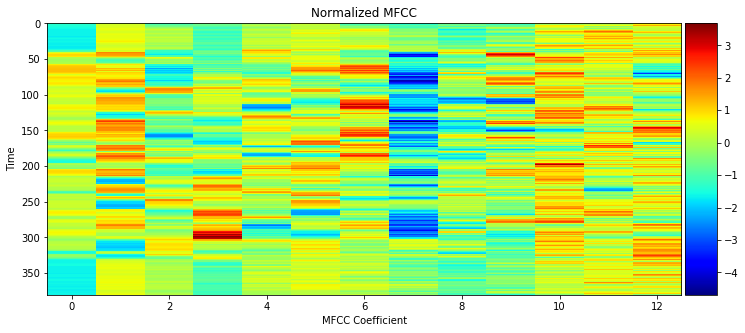

**Shape of MFCC** : (381, 13)

In [ ]:
from data_generator import plot_mfcc_feature

# plot normalized MFCC
plot_mfcc_feature(vis_mfcc_feature)
# print shape of MFCC
display(Markdown('**Shape of MFCC** : ' + str(vis_mfcc_feature.shape)))

When you construct your pipeline, you will be able to choose to use either spectrogram or MFCC features.  If you would like to see different implementations that make use of MFCCs and/or spectrograms, please check out the links below:
- This [repository](https://github.com/baidu-research/ba-dls-deepspeech) uses spectrograms.
- This [repository](https://github.com/mozilla/DeepSpeech) uses MFCCs.
- This [repository](https://github.com/buriburisuri/speech-to-text-wavenet) also uses MFCCs.
- This [repository](https://github.com/pannous/tensorflow-speech-recognition/blob/master/speech_data.py) experiments with raw audio, spectrograms, and MFCCs as features.

<a id='step2'></a>
## STEP 2: Deep Neural Networks for Acoustic Modeling

In this section, you will experiment with various neural network architectures for acoustic modeling.  

You will begin by training five relatively simple architectures.  **Model 0** is provided for you.  You will write code to implement **Models 1**, **2**, **3**, and **4**.  If you would like to experiment further, you are welcome to create and train more models under the **Models 5+** heading.  

All models will be specified in the `sample_models.py` file.  After importing the `sample_models` module, you will train your architectures in the notebook.

After experimenting with the five simple architectures, you will have the opportunity to compare their performance.  Based on your findings, you will construct a deeper architecture that is designed to outperform all of the shallow models.

For your convenience, we have designed the notebook so that each model can be specified and trained on separate occasions.  That is, say you decide to take a break from the notebook after training **Model 1**.  Then, you need not re-execute all prior code cells in the notebook before training **Model 2**.  You need only re-execute the code cell below, that is marked with **`RUN THIS CODE CELL IF YOU ARE RESUMING THE NOTEBOOK AFTER A BREAK`**, before transitioning to the code cells corresponding to **Model 2**.

In [28]:
#####################################################################
# RUN THIS CODE CELL IF YOU ARE RESUMING THE NOTEBOOK AFTER A BREAK #
#####################################################################
%reload_ext autoreload
# allocate 50% of GPU memory (if you like, feel free to change this)
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf 
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
set_session(tf.Session(config=config))

# watch for any changes in the sample_models module, and reload it automatically
%load_ext autoreload
%autoreload 2
# import NN architectures for speech recognition
from sample_models import *
# import function for training acoustic model
from train_utils import train_model

ModuleNotFoundError: ignored

In [26]:
!pip install 'tensorflow'

     |████████████████████████████████| 462 kB 9.0 MB/s 


In [29]:
!pip install 'keras.backend'

ERROR: Could not find a version that satisfies the requirement keras.backend (from versions: none)
ERROR: No matching distribution found for keras.backend


<a id='model0'></a>
### Model 0: RNN

Given their effectiveness in modeling sequential data, the first acoustic model you will use is an RNN.  As shown in the figure below, the RNN we supply to you will take the time sequence of audio features as input.

<img src="images/simple_rnn.png" width="50%">

At each time step, the speaker pronounces one of 28 possible characters, including each of the 26 letters in the English alphabet, along with a space character (" "), and an apostrophe (').

The output of the RNN at each time step is a vector of probabilities with 29 entries, where the $i$-th entry encodes the probability that the $i$-th character is spoken in the time sequence.  (The extra 29th character is an empty "character" used to pad training examples within batches containing uneven lengths.)  If you would like to peek under the hood at how characters are mapped to indices in the probability vector, look at the `char_map.py` file in the repository.  The figure below shows an equivalent, rolled depiction of the RNN that shows the output layer in greater detail. 

<img src="images/simple_rnn_unrolled.png" width="60%">

The model has already been specified for you in Keras.  To import it, you need only run the code cell below.  

In [ ]:
model_0 = simple_rnn_model(input_dim=161) # change to 13 if you would like to use MFCC features

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
rnn (GRU)                    (None, None, 29)          16617     
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total params: 16,617
Trainable params: 16,617
Non-trainable params: 0
_________________________________________________________________
None


As explored in the lesson, you will train the acoustic model with the [CTC loss](http://www.cs.toronto.edu/~graves/icml_2006.pdf) criterion.  Custom loss functions take a bit of hacking in Keras, and so we have implemented the CTC loss function for you, so that you can focus on trying out as many deep learning architectures as possible :).  If you'd like to peek at the implementation details, look at the `add_ctc_loss` function within the `train_utils.py` file in the repository.

To train your architecture, you will use the `train_model` function within the `train_utils` module; it has already been imported in one of the above code cells.  The `train_model` function takes three **required** arguments:
- `input_to_softmax` - a Keras model instance.
- `pickle_path` - the name of the pickle file where the loss history will be saved.
- `save_model_path` - the name of the HDF5 file where the model will be saved.

If we have already supplied values for `input_to_softmax`, `pickle_path`, and `save_model_path`, please **DO NOT** modify these values. 

There are several **optional** arguments that allow you to have more control over the training process.  You are welcome to, but not required to, supply your own values for these arguments.
- `minibatch_size` - the size of the minibatches that are generated while training the model (default: `20`).
- `spectrogram` - Boolean value dictating whether spectrogram (`True`) or MFCC (`False`) features are used for training (default: `True`).
- `mfcc_dim` - the size of the feature dimension to use when generating MFCC features (default: `13`).
- `optimizer` - the Keras optimizer used to train the model (default: `SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)`).  
- `epochs` - the number of epochs to use to train the model (default: `20`).  If you choose to modify this parameter, make sure that it is *at least* 20.
- `verbose` - controls the verbosity of the training output in the `model.fit_generator` method (default: `1`).
- `sort_by_duration` - Boolean value dictating whether the training and validation sets are sorted by (increasing) duration before the start of the first epoch (default: `False`).

The `train_model` function defaults to using spectrogram features; if you choose to use these features, note that the acoustic model in `simple_rnn_model` should have `input_dim=161`.  Otherwise, if you choose to use MFCC features, the acoustic model should have `input_dim=13`.

We have chosen to use `GRU` units in the supplied RNN.  If you would like to experiment with `LSTM` or `SimpleRNN` cells, feel free to do so here.  If you change the `GRU` units to `SimpleRNN` cells in `simple_rnn_model`, you may notice that the loss quickly becomes undefined (`nan`) - you are strongly encouraged to check this for yourself!  This is due to the [exploding gradients problem](http://www.wildml.com/2015/10/recurrent-neural-networks-tutorial-part-3-backpropagation-through-time-and-vanishing-gradients/).  We have already implemented [gradient clipping](https://arxiv.org/pdf/1211.5063.pdf) in your optimizer to help you avoid this issue.

__IMPORTANT NOTE:__ If you notice that your gradient has exploded in any of the models below, feel free to explore more with gradient clipping (the `clipnorm` argument in your optimizer) or swap out any `SimpleRNN` cells for `LSTM` or `GRU` cells.  You can also try restarting the kernel to restart the training process.

In [ ]:
train_model(input_to_softmax=model_0, 
            pickle_path='model_0.pickle', 
            save_model_path='model_0.h5',
            spectrogram=True) # change to False if you would like to use MFCC features

Epoch 1/20
101/101 [==============================] - 273s 3s/step - loss: 874.7326 - val_loss: 758.4766
Epoch 2/20
101/101 [==============================] - 271s 3s/step - loss: 779.9090 - val_loss: 764.5282
Epoch 3/20
101/101 [==============================] - 270s 3s/step - loss: 779.3627 - val_loss: 755.5686
Epoch 4/20
101/101 [==============================] - 269s 3s/step - loss: 779.2526 - val_loss: 752.2395
Epoch 5/20
101/101 [==============================] - 271s 3s/step - loss: 779.2059 - val_loss: 757.8153
Epoch 6/20
101/101 [==============================] - 272s 3s/step - loss: 778.3696 - val_loss: 764.0521
Epoch 7/20
101/101 [==============================] - 271s 3s/step - loss: 778.3746 - val_loss: 752.7934
Epoch 8/20
101/101 [==============================] - 270s 3s/step - loss: 778.2185 - val_loss: 756.8697
Epoch 9/20
101/101 [==============================] - 271s 3s/step - loss: 777.9306 - val_loss: 759.6804
Epoch 10/20
101/101 [==============================] - 

<a id='model1'></a>
### (IMPLEMENTATION) Model 1: RNN + TimeDistributed Dense

Read about the [TimeDistributed](https://keras.io/layers/wrappers/) wrapper and the [BatchNormalization](https://keras.io/layers/normalization/) layer in the Keras documentation.  For your next architecture, you will add [batch normalization](https://arxiv.org/pdf/1510.01378.pdf) to the recurrent layer to reduce training times.  The `TimeDistributed` layer will be used to find more complex patterns in the dataset.  The unrolled snapshot of the architecture is depicted below.

<img src="images/rnn_model.png" width="60%">

The next figure shows an equivalent, rolled depiction of the RNN that shows the (`TimeDistrbuted`) dense and output layers in greater detail.  

<img src="images/rnn_model_unrolled.png" width="60%">

Use your research to complete the `rnn_model` function within the `sample_models.py` file.  The function should specify an architecture that satisfies the following requirements:
- The first layer of the neural network should be an RNN (`SimpleRNN`, `LSTM`, or `GRU`) that takes the time sequence of audio features as input.  We have added `GRU` units for you, but feel free to change `GRU` to `SimpleRNN` or `LSTM`, if you like!
- Whereas the architecture in `simple_rnn_model` treated the RNN output as the final layer of the model, you will use the output of your RNN as a hidden layer.  Use `TimeDistributed` to apply a `Dense` layer to each of the time steps in the RNN output.  Ensure that each `Dense` layer has `output_dim` units.

Use the code cell below to load your model into the `model_1` variable.  Use a value for `input_dim` that matches your chosen audio features, and feel free to change the values for `units` and `activation` to tweak the behavior of your recurrent layer.

In [30]:
model_1 = rnn_model(input_dim=161, # change to 13 if you would like to use MFCC features
                    units=200,
                    activation='relu')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 the_input (InputLayer)      [(None, None, 161)]       0         
                                                                 
 rnn (GRU)                   (None, None, 200)         217800    
                                                                 
 simp_rnn (BatchNormalizatio  (None, None, 200)        800       
 n)                                                              
                                                                 
 time_distributed (TimeDistr  (None, None, 29)         5829      
 ibuted)                                                         
                                                                 
 softmax (Activation)        (None, None, 29)          0         
                                                                 
Total params: 224,429
Trainable params: 224,029
Non-trainable

Please execute the code cell below to train the neural network you specified in `input_to_softmax`.  After the model has finished training, the model is [saved](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model) in the HDF5 file `model_1.h5`.  The loss history is [saved](https://wiki.python.org/moin/UsingPickle) in `model_1.pickle`.  You are welcome to tweak any of the optional parameters while calling the `train_model` function, but this is not required.

<a id='model2'></a>
### (IMPLEMENTATION) Model 2: CNN + RNN + TimeDistributed Dense

The architecture in `cnn_rnn_model` adds an additional level of complexity, by introducing a [1D convolution layer](https://keras.io/layers/convolutional/#conv1d).  

<img src="images/cnn_rnn_model.png" width="100%">

This layer incorporates many arguments that can be (optionally) tuned when calling the `cnn_rnn_model` module.  We provide sample starting parameters, which you might find useful if you choose to use spectrogram audio features.  

If you instead want to use MFCC features, these arguments will have to be tuned.  Note that the current architecture only supports values of `'same'` or `'valid'` for the `conv_border_mode` argument.

When tuning the parameters, be careful not to choose settings that make the convolutional layer overly small.  If the temporal length of the CNN layer is shorter than the length of the transcribed text label, your code will throw an error.

Before running the code cell below, you must modify the `cnn_rnn_model` function in `sample_models.py`.  Please add batch normalization to the recurrent layer, and provide the same `TimeDistributed` layer as before.

In [33]:
model_2 = cnn_rnn_model(input_dim=161, # change to 13 if you would like to use MFCC features
                        filters=200,
                        kernel_size=11, 
                        conv_stride=2,
                        conv_border_mode='valid',
                        units=200)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 the_input (InputLayer)      [(None, None, 161)]       0         
                                                                 
 conv1d (Conv1D)             (None, None, 200)         354400    
                                                                 
 bn_conv_1d (BatchNormalizat  (None, None, 200)        800       
 ion)                                                            
                                                                 
 rnn (SimpleRNN)             (None, None, 200)         80200     
                                                                 
 simp_rnn (BatchNormalizatio  (None, None, 200)        800       
 n)                                                              
                                                                 
 time_distributed_1 (TimeDis  (None, None, 29)         5829

Please execute the code cell below to train the neural network you specified in `input_to_softmax`.  After the model has finished training, the model is [saved](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model) in the HDF5 file `model_2.h5`.  The loss history is [saved](https://wiki.python.org/moin/UsingPickle) in `model_2.pickle`.  You are welcome to tweak any of the optional parameters while calling the `train_model` function, but this is not required.

<a id='model3'></a>
### (IMPLEMENTATION) Model 3: Deeper RNN + TimeDistributed Dense

Review the code in `rnn_model`, which makes use of a single recurrent layer.  Now, specify an architecture in `deep_rnn_model` that utilizes a variable number `recur_layers` of recurrent layers.  The figure below shows the architecture that should be returned if `recur_layers=2`.  In the figure, the output sequence of the first recurrent layer is used as input for the next recurrent layer.

<img src="images/deep_rnn_model.png" width="80%">

Feel free to change the supplied values of `units` to whatever you think performs best.  You can change the value of `recur_layers`, as long as your final value is greater than 1. (As a quick check that you have implemented the additional functionality in `deep_rnn_model` correctly, make sure that the architecture that you specify here is identical to `rnn_model` if `recur_layers=1`.)

In [35]:
model_3 = deep_rnn_model(input_dim=161, # change to 13 if you would like to use MFCC features
                         units=200,
                         recur_layers=2) 

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 the_input (InputLayer)      [(None, None, 161)]       0         
                                                                 
 rnn_1 (GRU)                 (None, None, 200)         217800    
                                                                 
 batch_normalization (BatchN  (None, None, 200)        800       
 ormalization)                                                   
                                                                 
 rnn_2 (GRU)                 (None, None, 200)         241200    
                                                                 
 batch_normalization_1 (Batc  (None, None, 200)        800       
 hNormalization)                                                 
                                                                 
 time_distributed_2 (TimeDis  (None, None, 29)         5829

Please execute the code cell below to train the neural network you specified in `input_to_softmax`.  After the model has finished training, the model is [saved](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model) in the HDF5 file `model_3.h5`.  The loss history is [saved](https://wiki.python.org/moin/UsingPickle) in `model_3.pickle`.  You are welcome to tweak any of the optional parameters while calling the `train_model` function, but this is not required.

<a id='model4'></a>
### (IMPLEMENTATION) Model 4: Bidirectional RNN + TimeDistributed Dense

Read about the [Bidirectional](https://keras.io/layers/wrappers/) wrapper in the Keras documentation.  For your next architecture, you will specify an architecture that uses a single bidirectional RNN layer, before a (`TimeDistributed`) dense layer.  The added value of a bidirectional RNN is described well in [this paper](http://www.cs.toronto.edu/~hinton/absps/DRNN_speech.pdf).
> One shortcoming of conventional RNNs is that they are only able to make use of previous context. In speech recognition, where whole utterances are transcribed at once, there is no reason not to exploit future context as well.  Bidirectional RNNs (BRNNs) do this by processing the data in both directions with two separate hidden layers which are then fed forwards to the same output layer.

<img src="images/bidirectional_rnn_model.png" width="80%">

Before running the code cell below, you must complete the `bidirectional_rnn_model` function in `sample_models.py`.  Feel free to use `SimpleRNN`, `LSTM`, or `GRU` units.  When specifying the `Bidirectional` wrapper, use `merge_mode='concat'`.

In [37]:
model_4 = bidirectional_rnn_model(input_dim=161, # change to 13 if you would like to use MFCC features
                                  units=200)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 the_input (InputLayer)      [(None, None, 161)]       0         
                                                                 
 bidirectional (Bidirectiona  (None, None, 400)        435600    
 l)                                                              
                                                                 
 time_distributed_3 (TimeDis  (None, None, 29)         11629     
 tributed)                                                       
                                                                 
 softmax (Activation)        (None, None, 29)          0         
                                                                 
Total params: 447,229
Trainable params: 447,229
Non-trainable params: 0
_________________________________________________________________
None


Please execute the code cell below to train the neural network you specified in `input_to_softmax`.  After the model has finished training, the model is [saved](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model) in the HDF5 file `model_4.h5`.  The loss history is [saved](https://wiki.python.org/moin/UsingPickle) in `model_4.pickle`.  You are welcome to tweak any of the optional parameters while calling the `train_model` function, but this is not required.

In [ ]:
train_model(input_to_softmax=model_4, 
            pickle_path='model_4.pickle', 
            save_model_path='model_4.h5', 
            spectrogram=True) # change to False if you would like to use MFCC features

Epoch 1/20
101/101 [==============================] - 364s 4s/step - loss: 287.4961 - val_loss: 229.2572
Epoch 2/20
101/101 [==============================] - 378s 4s/step - loss: 213.2344 - val_loss: 197.7507
Epoch 3/20
101/101 [==============================] - 383s 4s/step - loss: 197.9805 - val_loss: 192.1415
Epoch 4/20
101/101 [==============================] - 372s 4s/step - loss: 188.4792 - val_loss: 178.7497
Epoch 5/20
101/101 [==============================] - 382s 4s/step - loss: 179.8995 - val_loss: 183.3381
Epoch 6/20
101/101 [==============================] - 379s 4s/step - loss: 172.5111 - val_loss: 169.1676
Epoch 7/20
101/101 [==============================] - 374s 4s/step - loss: 165.9683 - val_loss: 167.0060
Epoch 8/20
101/101 [==============================] - 376s 4s/step - loss: 159.0369 - val_loss: 165.0154
Epoch 9/20
101/101 [==============================] - 382s 4s/step - loss: 152.7491 - val_loss: 155.1056
Epoch 10/20
101/101 [==============================] - 

<a id='model5'></a>
### (OPTIONAL IMPLEMENTATION) Models 5+

If you would like to try out more architectures than the ones above, please use the code cell below.  Please continue to follow the same convention for saving the models; for the $i$-th sample model, please save the loss at **`model_i.pickle`** and saving the trained model at **`model_i.h5`**.

In [ ]:
## (Optional) TODO: Try out some more models!
### Feel free to use as many code cells as needed.

<a id='compare'></a>
### Compare the Models

Execute the code cell below to evaluate the performance of the drafted deep learning models.  The training and validation loss are plotted for each model.

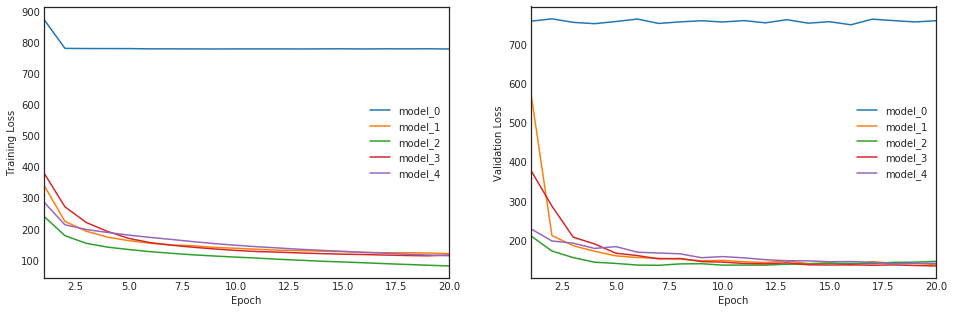

In [ ]:
from glob import glob
import numpy as np
import _pickle as pickle
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style(style='white')

# obtain the paths for the saved model history
all_pickles = sorted(glob("results/*.pickle"))
# extract the name of each model
model_names = [item[8:-7] for item in all_pickles]
# extract the loss history for each model
valid_loss = [pickle.load( open( i, "rb" ) )['val_loss'] for i in all_pickles]
train_loss = [pickle.load( open( i, "rb" ) )['loss'] for i in all_pickles]
# save the number of epochs used to train each model
num_epochs = [len(valid_loss[i]) for i in range(len(valid_loss))]

fig = plt.figure(figsize=(16,5))

# plot the training loss vs. epoch for each model
ax1 = fig.add_subplot(121)
for i in range(len(all_pickles)):
    ax1.plot(np.linspace(1, num_epochs[i], num_epochs[i]), 
            train_loss[i], label=model_names[i])
# clean up the plot
ax1.legend()  
ax1.set_xlim([1, max(num_epochs)])
plt.xlabel('Epoch')
plt.ylabel('Training Loss')

# plot the validation loss vs. epoch for each model
ax2 = fig.add_subplot(122)
for i in range(len(all_pickles)):
    ax2.plot(np.linspace(1, num_epochs[i], num_epochs[i]), 
            valid_loss[i], label=model_names[i])
# clean up the plot
ax2.legend()  
ax2.set_xlim([1, max(num_epochs)])
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.show()

## Comparison of CNN and RNN Models

['model_1', 'model_2']


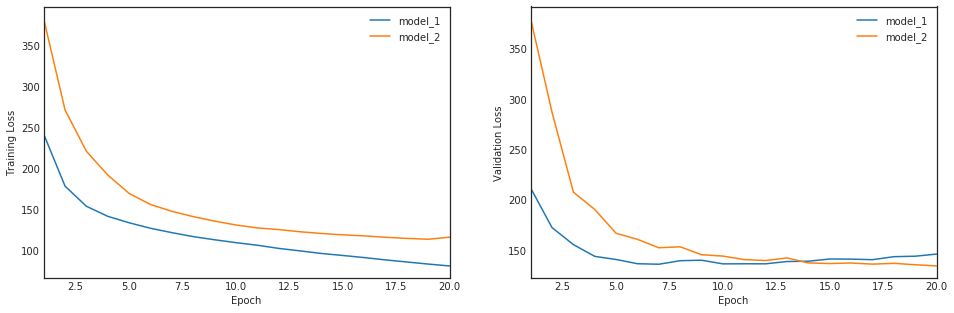

In [ ]:
from glob import glob
import numpy as np
import _pickle as pickle
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style(style='white')

# obtain the paths for the saved model history
all_pickles = sorted(glob("results/*.pickle"))
# extract the name of each model

model_names = [item[8:-8]+str(i+1) for i, item in enumerate(all_pickles)]
print(model_names)
# extract the loss history for each model
valid_loss = [pickle.load( open( i, "rb" ) )['val_loss'] for i in all_pickles]
train_loss = [pickle.load( open( i, "rb" ) )['loss'] for i in all_pickles]
# save the number of epochs used to train each model
num_epochs = [len(valid_loss[i]) for i in range(len(valid_loss))]

fig = plt.figure(figsize=(16,5))

# plot the training loss vs. epoch for each model
ax1 = fig.add_subplot(121)
for i in range(len(all_pickles)):
    ax1.plot(np.linspace(1, num_epochs[i], num_epochs[i]), 
            train_loss[i], label=model_names[i])
# clean up the plot
ax1.legend()  
ax1.set_xlim([1, max(num_epochs)])
plt.xlabel('Epoch')
plt.ylabel('Training Loss')

# plot the validation loss vs. epoch for each model
ax2 = fig.add_subplot(122)
for i in range(len(all_pickles)):
    ax2.plot(np.linspace(1, num_epochs[i], num_epochs[i]), 
            valid_loss[i], label=model_names[i])
# clean up the plot
ax2.legend()  
ax2.set_xlim([1, max(num_epochs)])
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.show()

__Question 1:__ Use the plot above to analyze the performance of each of the attempted architectures.  Which performs best?  Provide an explanation regarding why you think some models perform better than others. 

__Answer:__ **Model 2 has lower training loss but higher validation loss compared to all models. This denotes the CNN layer though helps to lower the training loss it might be overfitting. Model 3 performs the best in validation loss because deeper RNN layers help better model sequential data. Bidirectional doesn't seem to help much as the length of sequential input is not much. In short, deeper RNNs performs the best in validation loss.**

<a id='final'></a>
### (IMPLEMENTATION) Final Model: Pooled CNN + Deep Bidirectional RNN + TimeDistributed Dense

Now that you've tried out many sample models, use what you've learned to draft your own architecture!  While your final acoustic model should not be identical to any of the architectures explored above, you are welcome to merely combine the explored layers above into a deeper architecture.  It is **NOT** necessary to include new layer types that were not explored in the notebook.

However, if you would like some ideas for even more layer types, check out these ideas for some additional, optional extensions to your model:

- If you notice your model is overfitting to the training dataset, consider adding **dropout**!  To add dropout to [recurrent layers](https://faroit.github.io/keras-docs/1.0.2/layers/recurrent/), pay special attention to the `dropout_W` and `dropout_U` arguments.  This [paper](http://arxiv.org/abs/1512.05287) may also provide some interesting theoretical background.
- If you choose to include a convolutional layer in your model, you may get better results by working with **dilated convolutions**.  If you choose to use dilated convolutions, make sure that you are able to accurately calculate the length of the acoustic model's output in the `model.output_length` lambda function.  You can read more about dilated convolutions in Google's [WaveNet paper](https://arxiv.org/abs/1609.03499).  For an example of a speech-to-text system that makes use of dilated convolutions, check out this GitHub [repository](https://github.com/buriburisuri/speech-to-text-wavenet).  You can work with dilated convolutions [in Keras](https://keras.io/layers/convolutional/) by paying special attention to the `padding` argument when you specify a convolutional layer.
- If your model makes use of convolutional layers, why not also experiment with adding **max pooling**?  Check out [this paper](https://arxiv.org/pdf/1701.02720.pdf) for example architecture that makes use of max pooling in an acoustic model.
- So far, you have experimented with a single bidirectional RNN layer.  Consider stacking the bidirectional layers, to produce a [deep bidirectional RNN](https://www.cs.toronto.edu/~graves/asru_2013.pdf)!

All models that you specify in this repository should have `output_length` defined as an attribute.  This attribute is a lambda function that maps the (temporal) length of the input acoustic features to the (temporal) length of the output softmax layer.  This function is used in the computation of CTC loss; to see this, look at the `add_ctc_loss` function in `train_utils.py`.  To see where the `output_length` attribute is defined for the models in the code, take a look at the `sample_models.py` file.  You will notice this line of code within most models:
```
model.output_length = lambda x: x
```
The acoustic model that incorporates a convolutional layer (`cnn_rnn_model`) has a line that is a bit different:
```
model.output_length = lambda x: cnn_output_length(
        x, kernel_size, conv_border_mode, conv_stride)
```

In the case of models that use purely recurrent layers, the lambda function is the identity function, as the recurrent layers do not modify the (temporal) length of their input tensors.  However, convolutional layers are more complicated and require a specialized function (`cnn_output_length` in `sample_models.py`) to determine the temporal length of their output.

You will have to add the `output_length` attribute to your final model before running the code cell below.  Feel free to use the `cnn_output_length` function, if it suits your model. 

In [ ]:
# specify the model
model_end = final_model(input_dim=161,
                        filters=200,
                        kernel_size=11, 
                        conv_stride=2,
                        conv_border_mode='valid', units=200, recur_layers=2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 200)         354400    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 200)         0         
_________________________________________________________________
bn_conv_1d (BatchNormalizati (None, None, 200)         800       
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 400)         481200    
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 400)         1600      
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 400)         721200    
__________

Please execute the code cell below to train the neural network you specified in `input_to_softmax`.  After the model has finished training, the model is [saved](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model) in the HDF5 file `model_end.h5`.  The loss history is [saved](https://wiki.python.org/moin/UsingPickle) in `model_end.pickle`.  You are welcome to tweak any of the optional parameters while calling the `train_model` function, but this is not required.

In [ ]:
from keras.optimizers import SGD

train_model(input_to_softmax=model_end, 
            pickle_path='model_end.pickle', 
            save_model_path='model_end.h5', 
            spectrogram=True,# change to False if you would like to use MFCC features
            optimizer=SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=1)) 


Epoch 1/20
101/101 [==============================] - 338s 3s/step - loss: 250.1421 - val_loss: 239.5834
Epoch 2/20
101/101 [==============================] - 343s 3s/step - loss: 230.6022 - val_loss: 223.3686
Epoch 3/20
101/101 [==============================] - 342s 3s/step - loss: 227.0530 - val_loss: 219.8539
Epoch 4/20
101/101 [==============================] - 346s 3s/step - loss: 224.5615 - val_loss: 215.6194
Epoch 5/20
101/101 [==============================] - 340s 3s/step - loss: 222.9087 - val_loss: 217.9209
Epoch 6/20
101/101 [==============================] - 337s 3s/step - loss: 221.2279 - val_loss: 215.5162
Epoch 7/20
101/101 [==============================] - 335s 3s/step - loss: 220.2173 - val_loss: 217.4946
Epoch 8/20
101/101 [==============================] - 333s 3s/step - loss: 219.0024 - val_loss: 211.1025
Epoch 9/20
101/101 [==============================] - 335s 3s/step - loss: 217.8473 - val_loss: 214.9443
Epoch 10/20
101/101 [==============================] - 

__Question 2:__ Describe your final model architecture and your reasoning at each step.  

__Answer:__ In the comparison above, deep RNN layers performed the best. Hence in the final model, **Deep Bidirectional RNNs combined with CNN** are tried out to get best results.

<a id='step3'></a>
## STEP 3: Obtain Predictions

We have written a function for you to decode the predictions of your acoustic model.  To use the function, please execute the code cell below.

In [ ]:
import numpy as np
from data_generator import AudioGenerator
from keras import backend as K
from utils import int_sequence_to_text
from IPython.display import Audio

def get_predictions(index, partition, input_to_softmax, model_path):
    """ Print a model's decoded predictions
    Params:
        index (int): The example you would like to visualize
        partition (str): One of 'train' or 'validation'
        input_to_softmax (Model): The acoustic model
        model_path (str): Path to saved acoustic model's weights
    """
    # load the train and test data
    data_gen = AudioGenerator()
    data_gen.load_train_data()
    data_gen.load_validation_data()
    
    # obtain the true transcription and the audio features 
    if partition == 'validation':
        transcr = data_gen.valid_texts[index]
        audio_path = data_gen.valid_audio_paths[index]
        data_point = data_gen.normalize(data_gen.featurize(audio_path))
    elif partition == 'train':
        transcr = data_gen.train_texts[index]
        audio_path = data_gen.train_audio_paths[index]
        data_point = data_gen.normalize(data_gen.featurize(audio_path))
    else:
        raise Exception('Invalid partition!  Must be "train" or "validation"')
        
    # obtain and decode the acoustic model's predictions
    input_to_softmax.load_weights(model_path)
    prediction = input_to_softmax.predict(np.expand_dims(data_point, axis=0))
    output_length = [input_to_softmax.output_length(data_point.shape[0])] 
    pred_ints = (K.eval(K.ctc_decode(
                prediction, output_length)[0][0])+1).flatten().tolist()
    
    # play the audio file, and display the true and predicted transcriptions
    print('-'*80)
    Audio(audio_path)
    print('True transcription:\n' + '\n' + transcr)
    print('-'*80)
    print('Predicted transcription:\n' + '\n' + ''.join(int_sequence_to_text(pred_ints)))
    print('-'*80)

Use the code cell below to obtain the transcription predicted by your final model for the first example in the training dataset.

In [ ]:
get_predictions(index=0, 
                partition='train',
                input_to_softmax=deep_rnn_model(input_dim=161,
                         units=200,
                         recur_layers=2), 
                model_path='results/model_3.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
rnn_1 (GRU)                  (None, None, 200)         217200    
_________________________________________________________________
batch_normalization_9 (Batch (None, None, 200)         800       
_________________________________________________________________
rnn_2 (GRU)                  (None, None, 200)         240600    
_________________________________________________________________
batch_normalization_10 (Batc (None, None, 200)         800       
_________________________________________________________________
time_distributed_5 (TimeDist (None, None, 29)          5829      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total para

Use the next code cell to visualize the model's prediction for the first example in the validation dataset.

In [ ]:
get_predictions(index=0, 
                partition='validation',
                input_to_softmax=deep_rnn_model(input_dim=161,
                         units=200,
                         recur_layers=2), 
                model_path='results/model_3.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
rnn_1 (GRU)                  (None, None, 200)         217200    
_________________________________________________________________
batch_normalization_11 (Batc (None, None, 200)         800       
_________________________________________________________________
rnn_2 (GRU)                  (None, None, 200)         240600    
_________________________________________________________________
batch_normalization_12 (Batc (None, None, 200)         800       
_________________________________________________________________
time_distributed_6 (TimeDist (None, None, 29)          5829      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total para

One standard way to improve the results of the decoder is to incorporate a language model.  We won't pursue this in the notebook, but you are welcome to do so as an _optional extension_. 

**If you are interested in creating models that provide improved transcriptions, you are encouraged to download [more data](http://www.openslr.org/12/) and train bigger, deeper models.  But beware - the model will likely take a long while to train.  For instance, training this [state-of-the-art](https://arxiv.org/pdf/1512.02595v1.pdf) model would take 3-6 weeks on a single GPU!**

In [ ]:
!tar cvfz Speech_Recognition.tar.gz *